In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


File loaded successfully!

Dataset Preview:
                       name  year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3    Datsun RediGO T Option  2017         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  


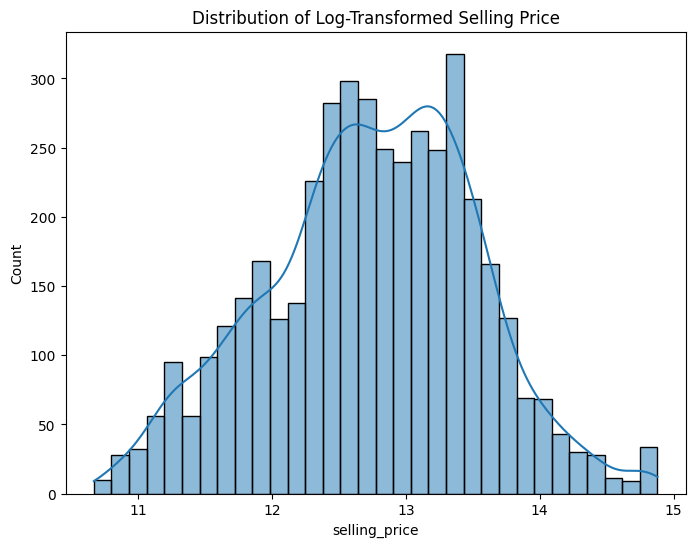

Cross-validated R² Scores: [0.72976166 0.71770796 0.72735844 0.69728305 0.74210893]
Mean Cross-validated R²: 0.72

Model Evaluation Metrics:
Mean Absolute Error (MAE): 107441.14
Mean Squared Error (MSE): 36751575190.23
R² Score: 0.75
Mean Absolute Percentage Error (MAPE): 28.23%

Predicted Selling Price for the New Car: $696,190.25


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/gred/CAR DETAILS FROM CAR DEKHO.csv'  # Update with your file path
df = pd.read_csv(file_path)

print("File loaded successfully!")
print("\nDataset Preview:")
print(df.head())

# 1. Feature Engineering: Extract 'brand' from 'name'
df['brand'] = df['name'].str.split().str[0]  # Extract first word as brand
le_brand = LabelEncoder()
df['brand'] = le_brand.fit_transform(df['brand'])

# 2. Preprocessing Function
def preprocess_data(df):
    # Encode categorical features
    label_encoders = {}
    for column in ['fuel', 'seller_type', 'transmission', 'owner']:
        if column in df.columns:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
            label_encoders[column] = le

    # Add 'Age' column and drop 'year'
    if 'year' in df.columns:
        df['Age'] = 2024 - df['year']
        df.drop('year', axis=1, inplace=True)

    return df, label_encoders

# Preprocess the data
df, encoders = preprocess_data(df)

# Log transform 'selling_price'
df['selling_price'] = np.log1p(df['selling_price'])

# 3. Remove Outliers
q1 = df['selling_price'].quantile(0.25)
q3 = df['selling_price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['selling_price'] >= lower_bound) & (df['selling_price'] <= upper_bound)]

# Plot distribution of selling_price after log transformation
plt.figure(figsize=(8, 6))
sns.histplot(df['selling_price'], kde=True)
plt.title("Distribution of Log-Transformed Selling Price")
plt.show()

# 4. Features (X) and Target (y)
X = df.drop(['selling_price', 'name'], axis=1, errors='ignore')
y = df['selling_price']

# Reset index after filtering
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features (if needed)
scaler = StandardScaler()
X_train[['km_driven', 'Age']] = scaler.fit_transform(X_train[['km_driven', 'Age']])
X_test[['km_driven', 'Age']] = scaler.transform(X_test[['km_driven', 'Age']])

# 5. Train Model: Gradient Boosting Regressor
model = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1, max_depth=15)
model.fit(X_train, y_train)

# Cross-Validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² Scores: {cv_scores}")
print(f"Mean Cross-validated R²: {np.mean(cv_scores):.2f}")

# Predictions and reverse log transformation
y_pred = np.expm1(model.predict(X_test))

# Evaluate the model
y_test_original = np.expm1(y_test)  # Reverse log transformation for comparison
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred)

print("\nModel Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# 6. Example Prediction for a New Car
new_car = {
    'km_driven': 55000,
    'fuel': 'Petrol',
    'seller_type': 'Dealer',
    'transmission': 'Manual',
    'owner': 'First Owner',
    'Age': 6,
    'brand': le_brand.transform(['Toyota'])[0]  # Encode 'Toyota' brand
}

# Convert the new car data into a DataFrame
new_car_df = pd.DataFrame([new_car])

# Encode categorical fields for the new car
for column in ['fuel', 'seller_type', 'transmission', 'owner']:
    if column in new_car_df.columns:
        try:
            new_car_df[column] = encoders[column].transform(new_car_df[column])
        except ValueError:
            print(f"Unseen label in column '{column}'. Replacing with a default value.")
            new_car_df[column] = 0  # Replace with a default value

# Scale numerical features
new_car_df[['km_driven', 'Age']] = scaler.transform(new_car_df[['km_driven', 'Age']])

# Ensure the input matches the training features
new_car_df = new_car_df[X.columns]

# Predict the price of the new car and reverse log transformation
predicted_price = np.expm1(model.predict(new_car_df))
print(f"\nPredicted Selling Price for the New Car: ${predicted_price[0]:,.2f}")
